In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# We will use this port number for monitoring Spark Jobs
port=4050

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', str(port))\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "4g")\
        .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

spark

23/05/14 19:19:12 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.91.54.55 instead (on interface en0)
23/05/14 19:19:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/14 19:19:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

print("Driver Memory: ", sc._conf.get('spark.driver.memory'))
print("Executor Memory: ", sc._conf.get('spark.executor.memory'))

Driver Memory:  4g
Executor Memory:  4g


In [4]:
# read /Users/husseinyounes/University/big_data/San-Francisco-Crime-Classification-bigdata/data/train.csv
import pandas as pd

file_path = '/Users/husseinyounes/University/big_data/San-Francisco-Crime-Classification-bigdata/data/train.csv'

# read the data
data = pd.read_csv(file_path)
data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [5]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [23]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, BooleanType, DateType, TimestampType, DoubleType

schema = StructType([
    StructField("Dates", TimestampType(), True),
    StructField("Category", StringType(), True),
    StructField("Descript", StringType(), True),
    StructField("DayOfWeek", StringType(), True),
    StructField("PdDistrict", StringType(), True),
    StructField("Resolution", StringType(), True),
    StructField("Address", StringType(), True),
    StructField("X", DoubleType(), True),
    StructField("Y", DoubleType(), True)
])

# read the data
df = spark.read.csv(file_path, header=True, schema=schema)
df.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [7]:
# get the resolution sorted by frequency
df.groupBy("Resolution").count().orderBy("count", ascending=False).distinct().select("Resolution").show(truncate=False)

+--------------------------------------+
|Resolution                            |
+--------------------------------------+
|NONE                                  |
|ARREST, BOOKED                        |
|ARREST, CITED                         |
|LOCATED                               |
|PSYCHOPATHIC CASE                     |
|UNFOUNDED                             |
|JUVENILE BOOKED                       |
|COMPLAINANT REFUSES TO PROSECUTE      |
|DISTRICT ATTORNEY REFUSES TO PROSECUTE|
|NOT PROSECUTED                        |
|JUVENILE CITED                        |
|PROSECUTED BY OUTSIDE AGENCY          |
|EXCEPTIONAL CLEARANCE                 |
|JUVENILE ADMONISHED                   |
|JUVENILE DIVERTED                     |
|CLEARED-CONTACT JUVENILE FOR MORE INFO|
|PROSECUTED FOR LESSER OFFENSE         |
+--------------------------------------+



In [8]:
df.dtypes

[('Dates', 'timestamp'),
 ('Category', 'string'),
 ('Descript', 'string'),
 ('DayOfWeek', 'string'),
 ('PdDistrict', 'string'),
 ('Resolution', 'string'),
 ('Address', 'string'),
 ('X', 'string'),
 ('Y', 'string')]

In [9]:
df

Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION...,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747
2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION...,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREE...,-122.42436302145,37.8004143219856
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,NORTHERN,NONE,1500 Block of LOM...,-122.42699532676599,37.80087263276921
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,PARK,NONE,100 Block of BROD...,-122.438737622757,37.771541172057795
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.40325236121201,37.713430704116
2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423326976668,37.7251380403778
2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DON...,-122.371274317441,37.7275640719518
2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194031117,37.776601260681204
2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,CENTRAL,NONE,JEFFERSON ST / LE...,-122.419087676747,37.8078015516515


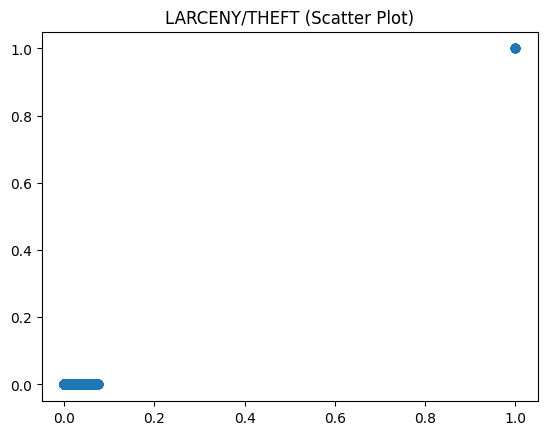

Unable to plot KDE for category: LARCENY/THEFT


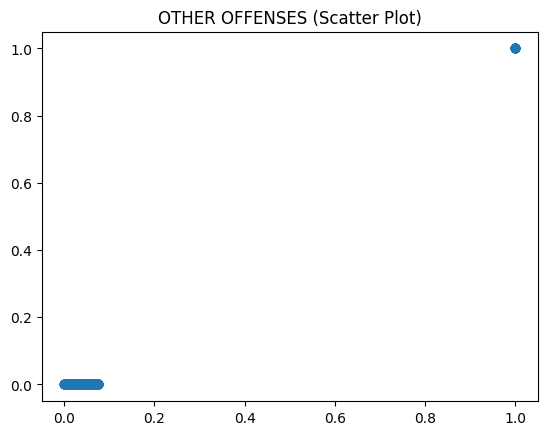

Unable to plot KDE for category: OTHER OFFENSES


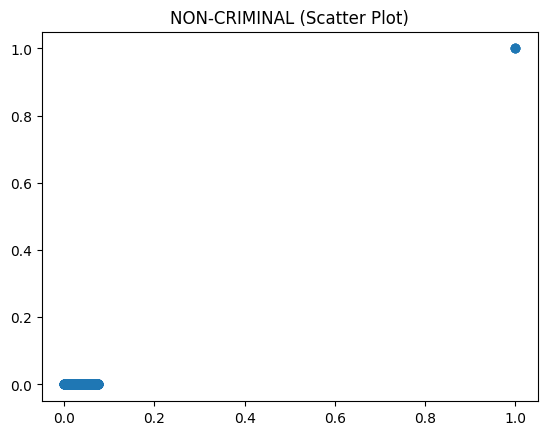

Unable to plot KDE for category: NON-CRIMINAL


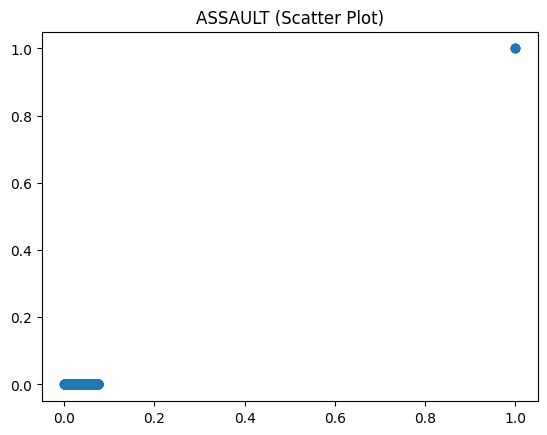

Unable to plot KDE for category: ASSAULT


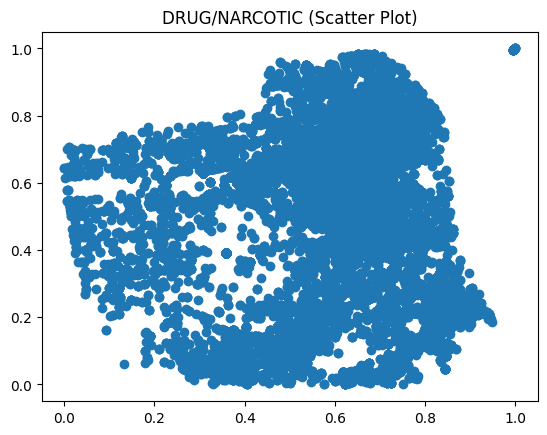

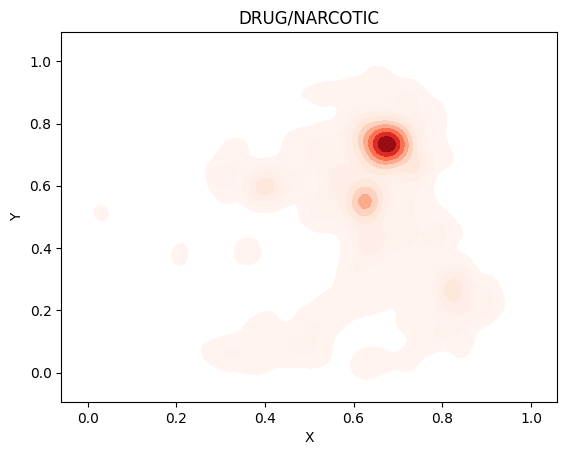

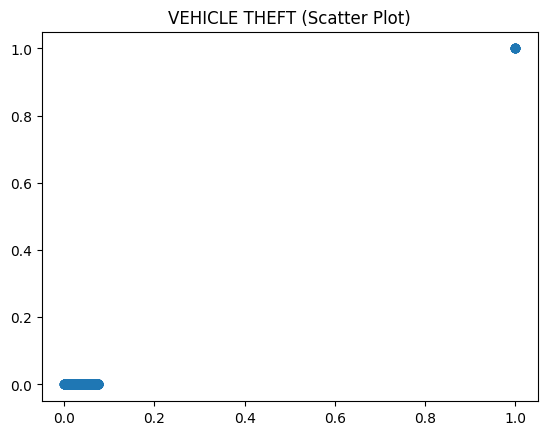

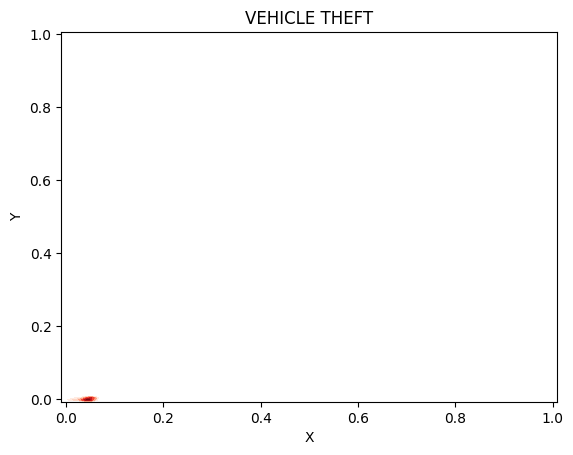

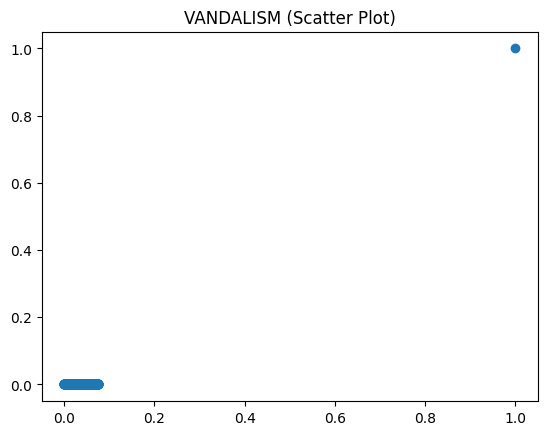

Unable to plot KDE for category: VANDALISM


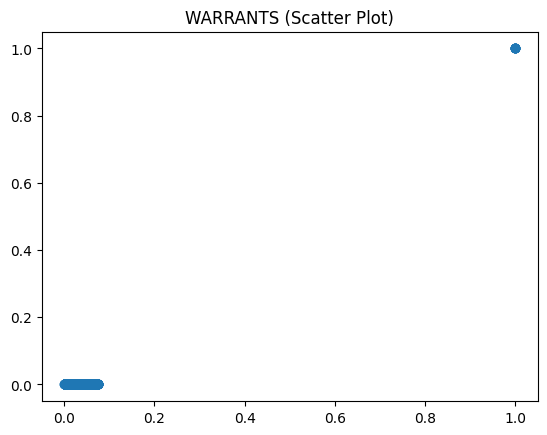

Unable to plot KDE for category: WARRANTS


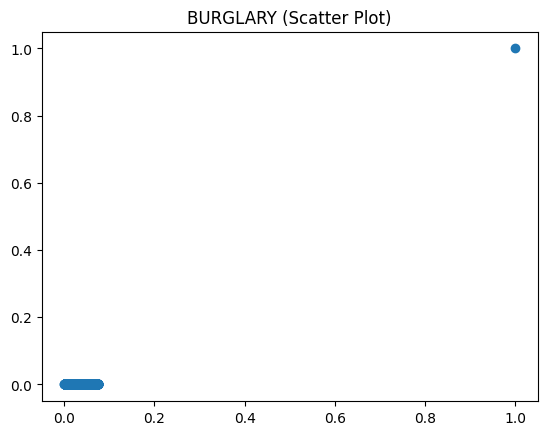

Unable to plot KDE for category: BURGLARY


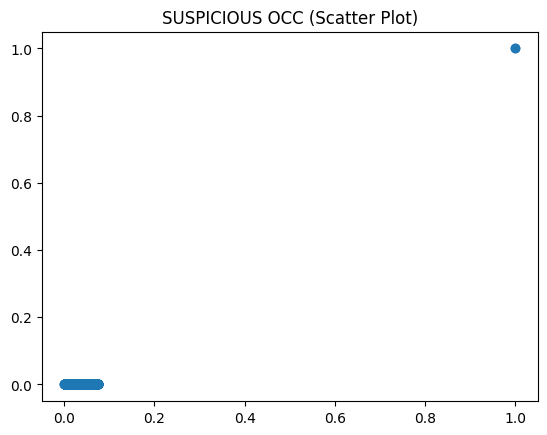

Unable to plot KDE for category: SUSPICIOUS OCC


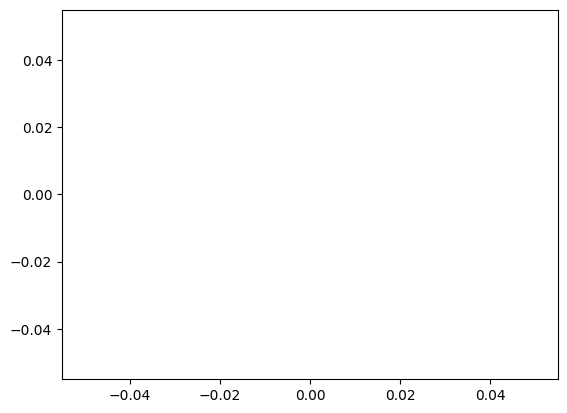

In [27]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

top_10_categories = df.groupBy("Category").count().orderBy("count", ascending=False).distinct().select("Category").limit(10).toPandas()

# get count per coorinates for each category
for category in top_10_categories["Category"]:
    # filter the DataFrame for the specific category
    category_df = df.filter(df["Category"] == category).select("X", "Y").toPandas()
    
    # remove NaN values
    category_df = category_df.dropna()
    
    # rescale the X, Y coordinates
    category_df[["X", "Y"]] = scaler.fit_transform(category_df[["X", "Y"]])
    
    # plot the data as a scatter plot
    plt.scatter(category_df["X"], category_df["Y"])
    plt.title(category + " (Scatter Plot)")
    plt.show()
    
    # plot the heatmap using the X, Y coordinates
    try:
        sns.kdeplot(category_df["X"], category_df["Y"], shade=True, cmap="Reds")
        plt.title(category)
        plt.show()
    except ValueError:
        print("Unable to plot KDE for category:", category)


In [10]:
from pyspark.ml.feature import ChiSqSelector, StringIndexer, OneHotEncoder, VectorAssembler

cat_cols = ['DayOfWeek', 'PdDistrict', 'Resolution']

df_new = df

indexer = StringIndexer(inputCol='Category', outputCol='Category_index')
df_new = indexer.fit(df_new).transform(df_new)

# convert categorical columns to numerical
for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_index')
    encoder = OneHotEncoder(inputCols=[col+'_index'], outputCols=[col+'_vec'])
    df_new = indexer.fit(df_new).transform(df_new)
    df_new = encoder.fit(df_new).transform(df_new)

# assemble the features
assembler = VectorAssembler(inputCols=['DayOfWeek_vec', 'PdDistrict_vec', 'Resolution_vec'], outputCol='features')

df_new = assembler.transform(df_new)

selector = ChiSqSelector(numTopFeatures=10, featuresCol="features", outputCol="selectedFeatures", labelCol="Category_index")
selector_model = selector.fit(df_new)
result = selector_model.transform(df_new)

result

Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Category_index,DayOfWeek_index,DayOfWeek_vec,PdDistrict_index,PdDistrict_vec,Resolution_index,Resolution_vec,features,selectedFeatures
2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,7.0,1.0,"(6,[1],[1.0])",2.0,"(9,[2],[1.0])",1.0,"(16,[1],[1.0])","(31,[1,8,16],[1.0...","(10,[1,8],[1.0,1.0])"
2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION...,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,1.0,1.0,"(6,[1],[1.0])",2.0,"(9,[2],[1.0])",1.0,"(16,[1],[1.0])","(31,[1,8,16],[1.0...","(10,[1,8],[1.0,1.0])"
2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION...,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREE...,-122.42436302145,37.8004143219856,1.0,1.0,"(6,[1],[1.0])",2.0,"(9,[2],[1.0])",1.0,"(16,[1],[1.0])","(31,[1,8,16],[1.0...","(10,[1,8],[1.0,1.0])"
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,NORTHERN,NONE,1500 Block of LOM...,-122.42699532676599,37.80087263276921,0.0,1.0,"(6,[1],[1.0])",2.0,"(9,[2],[1.0])",0.0,"(16,[0],[1.0])","(31,[1,8,15],[1.0...","(10,[1,8],[1.0,1.0])"
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,PARK,NONE,100 Block of BROD...,-122.438737622757,37.771541172057795,0.0,1.0,"(6,[1],[1.0])",8.0,"(9,[8],[1.0])",0.0,"(16,[0],[1.0])","(31,[1,14,15],[1....","(10,[1],[1.0])"
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.40325236121201,37.713430704116,0.0,1.0,"(6,[1],[1.0])",6.0,"(9,[6],[1.0])",0.0,"(16,[0],[1.0])","(31,[1,12,15],[1....","(10,[1],[1.0])"
2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423326976668,37.7251380403778,5.0,1.0,"(6,[1],[1.0])",6.0,"(9,[6],[1.0])",0.0,"(16,[0],[1.0])","(31,[1,12,15],[1....","(10,[1],[1.0])"
2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DON...,-122.371274317441,37.7275640719518,5.0,1.0,"(6,[1],[1.0])",3.0,"(9,[3],[1.0])",0.0,"(16,[0],[1.0])","(31,[1,9,15],[1.0...","(10,[1,9],[1.0,1.0])"
2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194031117,37.776601260681204,0.0,1.0,"(6,[1],[1.0])",9.0,"(9,[],[])",0.0,"(16,[0],[1.0])","(31,[1,15],[1.0,1...","(10,[1],[1.0])"
2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,CENTRAL,NONE,JEFFERSON ST / LE...,-122.419087676747,37.8078015516515,0.0,1.0,"(6,[1],[1.0])",4.0,"(9,[4],[1.0])",0.0,"(16,[0],[1.0])","(31,[1,10,15],[1....","(10,[1],[1.0])"


In [11]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCols
from pyspark.sql.functions import udf, col, explode, dayofmonth, month, year, radians, sin, cos, lit
from pyspark.sql import DataFrame
import math


class DateTimeTransformer(Transformer, HasInputCol, HasOutputCols):
    def __init__(self, inputCol=None, outputCols=None):
        super(DateTimeTransformer, self).__init__()
        self._set(inputCol=inputCol)
        self._set(outputCols=outputCols)

    def _transform(self, df: DataFrame) -> DataFrame:
        input_col = self.getInputCol()
        output_cols = self.getOutputCols()

        df = df.withColumn(output_cols[0], sin(2 * math.pi * col(input_col) / 12))
        df = df.withColumn(output_cols[1], cos(2 * math.pi * col(input_col) / 12))

        return df

In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import (
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    HashingTF,
    IDF,
    Word2Vec,
    Tokenizer,
    MinMaxScaler,
    Word2VecModel,
    Word2Vec,
)
from pyspark.sql.functions import (
    udf,
    col,
    explode,
    dayofmonth,
    month,
    year,
    radians,
    sin,
    cos,
    lit,
)
from pyspark.sql.types import DoubleType, StringType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCols
from pyspark.sql import DataFrame
import math
from pyspark.ml.linalg import SparseVector


df_new = df

cat_features = ["DayOfWeek", "PdDistrict", "Resolution", "Category"]
num_features = ["X", "Y"]
text_features = ["Descript"]


df_new = df_new.withColumn("month", month("Dates"))
df_new = df_new.withColumn("year", year("Dates"))
df_new = df_new.withColumn("day", dayofmonth("Dates"))
df_new = df_new.withColumn(
    "hour", df_new.Dates.cast("string").substr(12, 2).cast("int")
)
df_new = df_new.withColumn(
    "minute", df_new.Dates.cast("string").substr(15, 2).cast("int")
)

date_time_features = ["day", "month", "year", "hour", "minute"]


# convert X, Y to float
df_new = df_new.withColumn("X", df_new["X"].cast("float"))
df_new = df_new.withColumn("Y", df_new["Y"].cast("float"))


# convert the string labels to numbers
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index").fit(df)
    for column in cat_features
]

# convert the numbers to one hot vectors
encoders = [
    OneHotEncoder(inputCol=column + "_index", outputCol=column + "_vec")
    for column in cat_features
]

# tokenize the text
tokenizers = [
    Tokenizer(inputCol=column, outputCol=f"{column}_words") for column in text_features
]

# convert the text to vectors using Word2Vec
word2Vecs = [
    Word2Vec(
        vectorSize=3, minCount=0, inputCol=f"{column}_words", outputCol=f"{column}_vec"
    )
    for column in text_features
]

date_time_encoders = [
    DateTimeTransformer(inputCol=column, outputCols=[f"{column}_sin", f"{column}_cos"])
    for column in date_time_features
]

# assemble the features
assembler = VectorAssembler(
    inputCols=[
        "DayOfWeek_vec",
        "PdDistrict_vec",
        "Resolution_vec",
        "Descript_vec",
        "X",
        "Y",
        "day_sin",
        "day_cos",
        "month_sin",
        "month_cos",
        "year_sin",
        "year_cos",
        "hour_sin",
        "hour_cos",
        "minute_sin",
        "minute_cos",
    ],
    outputCol="features",
)

# create a pipeline
pipeline = Pipeline(
    stages=indexers
    + encoders
    + tokenizers
    + word2Vecs
    + date_time_encoders
    + [assembler]
)

# fit the pipeline
model = pipeline.fit(df_new)
df_new = model.transform(df_new)

df_new


23/05/14 19:20:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/14 19:20:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


23/05/14 19:20:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month,year,day,hour,minute,DayOfWeek_index,PdDistrict_index,Resolution_index,Category_index,DayOfWeek_vec,PdDistrict_vec,Resolution_vec,Category_vec,Descript_words,Descript_vec,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,hour_sin,hour_cos,minute_sin,minute_cos,features
2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.42589,37.774597,5,2015,13,23,53,1.0,2.0,1.0,7.0,"(6,[1],[1.0])","(9,[2],[1.0])","(16,[1],[1.0])","(38,[7],[1.0])","[warrant, arrest]",[2.60127377510070...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,0.5000000000000004,-0.8660254037844384,"(46,[1,8,16,31,32..."
2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION...,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.42589,37.774597,5,2015,13,23,53,1.0,2.0,1.0,1.0,"(6,[1],[1.0])","(9,[2],[1.0])","(16,[1],[1.0])","(38,[1],[1.0])","[traffic, violati...",[0.83607788880666...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,0.5000000000000004,-0.8660254037844384,"(46,[1,8,16,31,32..."
2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION...,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREE...,-122.42436,37.800415,5,2015,13,23,33,1.0,2.0,1.0,1.0,"(6,[1],[1.0])","(9,[2],[1.0])","(16,[1],[1.0])","(38,[1],[1.0])","[traffic, violati...",[0.83607788880666...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,-1.0,1.102801099869206...,"(46,[1,8,16,31,32..."
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,NORTHERN,NONE,1500 Block of LOM...,-122.426994,37.800873,5,2015,13,23,30,1.0,2.0,0.0,0.0,"(6,[1],[1.0])","(9,[2],[1.0])","(16,[0],[1.0])","(38,[0],[1.0])","[grand, theft, fr...",[-1.8054602980613...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,2.388680238973927...,-1.0,"(46,[1,8,15,31,32..."
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,PARK,NONE,100 Block of BROD...,-122.438736,37.77154,5,2015,13,23,30,1.0,8.0,0.0,0.0,"(6,[1],[1.0])","(9,[8],[1.0])","(16,[0],[1.0])","(38,[0],[1.0])","[grand, theft, fr...",[-1.8054602980613...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,2.388680238973927...,-1.0,"(46,[1,14,15,31,3..."
2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM ...,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.40325,37.713432,5,2015,13,23,30,1.0,6.0,0.0,0.0,"(6,[1],[1.0])","(9,[6],[1.0])","(16,[0],[1.0])","(38,[0],[1.0])","[grand, theft, fr...",[-1.7171151041984...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,2.388680238973927...,-1.0,"(46,[1,12,15,31,3..."
2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423325,37.72514,5,2015,13,23,30,1.0,6.0,0.0,5.0,"(6,[1],[1.0])","(9,[6],[1.0])","(16,[0],[1.0])","(38,[5],[1.0])","[stolen, automobile]",[-7.5671638250350...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,2.388680238973927...,-1.0,"(46,[1,12,15,31,3..."
2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DON...,-122.37128,37.727566,5,2015,13,23,30,1.0,3.0,0.0,5.0,"(6,[1],[1.0])","(9,[3],[1.0])","(16,[0],[1.0])","(38,[5],[1.0])","[stolen, automobile]",[-7.5671638250350...,0.5,0.8660254037844386,0.49999999999999994,-0.8660254037844387,-0.5000000000000997,0.8660254037843811,-0.5000000000000014,0.8660254037844378,2.388680238973927...,-1.0,"(46,[1,9,15,31

In [13]:
df_new.select("DayOfWeek_index").distinct().show()

+---------------+
|DayOfWeek_index|
+---------------+
|            0.0|
|            1.0|
|            4.0|
|            3.0|
|            2.0|
|            6.0|
|            5.0|
+---------------+



In [12]:
# select ('features', 'category_index')
df_final = df_new.select('features', 'Category_index').withColumnRenamed('Category_index', 'label')
df_final.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(46,[1,8,16,31,32...|  7.0|
|(46,[1,8,16,31,32...|  1.0|
|(46,[1,8,16,31,32...|  1.0|
|(46,[1,8,15,31,32...|  0.0|
|(46,[1,14,15,31,3...|  0.0|
|(46,[1,12,15,31,3...|  0.0|
|(46,[1,12,15,31,3...|  5.0|
|(46,[1,9,15,31,32...|  5.0|
|(46,[1,15,31,32,3...|  0.0|
|(46,[1,10,15,31,3...|  0.0|
|(46,[1,10,15,31,3...|  0.0|
|(46,[1,13,15,31,3...|  1.0|
|(46,[1,11,15,31,3...|  6.0|
|(46,[1,8,15,31,32...|  0.0|
|(46,[1,9,15,31,32...|  2.0|
|(46,[1,9,15,31,32...|  2.0|
|(46,[1,11,15,31,3...| 11.0|
|(46,[1,12,15,31,3...|  3.0|
|(46,[1,9,16,31,32...|  1.0|
|(46,[1,11,15,31,3...|  2.0|
+--------------------+-----+
only showing top 20 rows



In [13]:
# Category_index uniqu
df_final.select('label').distinct().sort('label').show()

+-----+
|label|
+-----+
|  0.0|
|  1.0|
|  2.0|
|  3.0|
|  4.0|
|  5.0|
|  6.0|
|  7.0|
|  8.0|
|  9.0|
| 10.0|
| 11.0|
| 12.0|
| 13.0|
| 14.0|
| 15.0|
| 16.0|
| 17.0|
| 18.0|
| 19.0|
+-----+
only showing top 20 rows



In [14]:
# split the data
train_data, test_data = df_final.randomSplit([0.7, 0.3])

## Logistic Regression

In [33]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression


# create the model
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# fit the model
lr_model = lr.fit(train_data)

for iteration, loss in enumerate(lr_model.summary.objectiveHistory):
    print(f"Iteration {iteration}: Loss = {loss}")

Iteration 0: Loss = 2.6805224692650844
Iteration 1: Loss = 2.2552143493286216
Iteration 2: Loss = 1.8027961965389827
Iteration 3: Loss = 1.6219508539718897
Iteration 4: Loss = 1.4648099833874033
Iteration 5: Loss = 1.3537100866384157
Iteration 6: Loss = 1.29189427510797
Iteration 7: Loss = 1.243317464258179
Iteration 8: Loss = 1.2004382882580515
Iteration 9: Loss = 1.1697030915689903
Iteration 10: Loss = 1.1403089540072364


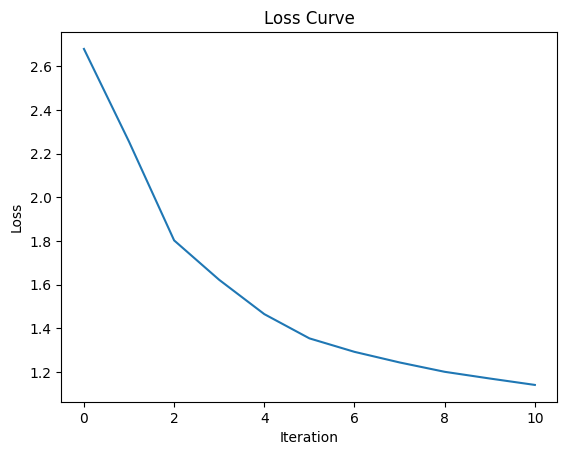

In [34]:
import matplotlib.pyplot as plt

# plot the loss for each iteration
plt.plot(lr_model.summary.objectiveHistory)
plt.title('Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [15]:
predictions = lr_model.transform(test_data)
predictions.select(['label', 'prediction']).show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  3.0|       3.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
+-----+----------+
only showing top 5 rows



In [16]:
# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# get the accuracy, f1, RMSE
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy: {}'.format(accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = evaluator.evaluate(predictions)
print('F1 Score: {}'.format(f1))

Accuracy: 0.7144806826927087


F1 Score: 0.6813237562766474


In [21]:
# get the paramters of the model, regParam, elasticNetParam
lr_model.explainParams()
# get the regParam
print(lr_model.getRegParam())
# get the elasticNetParam
print(lr_model.getElasticNetParam())
# maxIter
print(lr_model.getMaxIter())
# tol
print(lr_model.getTol())

0.0
0.0
10
1e-06


In [18]:
# hyper parameter tuning for Logistic Regression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

class LoggingEvaluator(MulticlassClassificationEvaluator):

    def __init__(self, **kwargs):
        super(LoggingEvaluator, self).__init__(**kwargs)

    def _evaluate(self, dataset):
        metric = super(LoggingEvaluator, self)._evaluate(dataset)
        # print the parameters
        print(f"RegParam: {lr_model.getRegParam()}")
        print(f"ElasticNetParam: {lr_model.getElasticNetParam()}")
        print(f"MaxIter: {lr_model.getMaxIter()}")
        print(f"Tol: {lr_model.getTol()}")
        print(f"Metric for current fold: {metric}")
        print("====================================")
        return metric




# create the grid of parameters
param_grid = {
    'regParam': [0.0, 0.1, 0.5],
    'elasticNetParam': [0.0, 0.5, 1.0],
    'maxIter': [5, 10],
    'tol': [1e-8, 1e-6, 1e-4],
}

param_grid = ParamGridBuilder(). \
        addGrid(lr.regParam, [0.0, 0.1, 0.5]). \
        addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]). \
        addGrid(lr.maxIter, [5, 10]). \
        addGrid(lr.tol, [1e-8, 1e-6, 1e-4]). \
        build()

# create the cross validator

logging_evaluator = LoggingEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
cross_val = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=logging_evaluator, numFolds=3)

# fit the model
cv_model = cross_val.fit(train_data)

# get the best model
best_model = cv_model.bestModel

RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.6621223358576002
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.6621223358576002
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.6621223358576002
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7154930127254274
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7154930127254274
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7154930127254274
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.6621223358576002
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.6621223358576002
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.6621223358576002
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold:

RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.394254040128035
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19922515418846123
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for curren

RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.66246813174983
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.66246813174983
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.66246813174983
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7168973903511991
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7168973903511991
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7168973903511991
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.66246813174983
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.66246813174983
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.66246813174983
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.716897390

RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3363917066701899
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3363917066701899
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3363917066701899
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3962183825364436
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3962183825364436
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3962183825364436
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3954403323595473
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3954403323595473


RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.3954403323595473
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.19977294636347176
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for curre

RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.659836365499173
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.659836365499173
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.659836365499173
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7150983807307446
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7150983807307446
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.7150983807307446
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.659836365499173
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.659836365499173
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.659836365499173
RegParam: 0.0
ElasticNetParam: 0.0
MaxIter: 10
Tol: 1e-06
Metric for current fold: 0.715

In [22]:
# print the parameters and the performance
print('Best Param (regParam): {}'.format(best_model._java_obj.getRegParam()))
print('Best Param (elasticNetParam): {}'.format(best_model._java_obj.getElasticNetParam()))
print('Best Param (maxIter): {}'.format(best_model._java_obj.getMaxIter()))
print('Best Param (tol): {}'.format(best_model._java_obj.getTol()))

# get the accuracy, f1
predictions = best_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy: {}'.format(accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = evaluator.evaluate(predictions)
print('F1 Score: {}'.format(f1))

Best Param (regParam): 0.0
Best Param (elasticNetParam): 0.0
Best Param (maxIter): 10
Best Param (tol): 1e-08


Accuracy: 0.7144806826927087


F1 Score: 0.6813237562766474


## Random Forest

In [3]:
# classify using Random Forest
from pyspark.ml.classification import RandomForestClassifier

# create the model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=24)

# fit the model
rf_model = rf.fit(train_data)

AssertionError: 

In [2]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

num_trees = [10, 20, 30]#, 50, 100, 200]
accuracies = []

for num_tree in num_trees:
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=24, numTrees=num_tree)
    rf_model = rf.fit(train_data)
    predictions = rf_model.transform(test_data)
    accuracy = evaluator.evaluate(predictions)
    accuracies.append(accuracy)

plt.plot(num_trees, accuracies)
# smooth the curve
plt.plot(num_trees, accuracies, 'o', color='black')
plt.title('Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.show()


AssertionError: 

In [16]:
predictions = rf_model.transform(test_data)
predictions.select(['label', 'prediction']).show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
|  2.0|       2.0|
+-----+----------+
only showing top 5 rows



In [17]:
# get the prediction accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

# evaluate using F1 score
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)
print(f"F1 score: {f1_score}")

Accuracy = 0.637293


F1 score: 0.5731772697222233


In [18]:
# print the parameters of the model
# numTrees
print(rf_model.getNumTrees)
# maxDepth
print(rf_model.getMaxDepth())
# maxBins
print(rf_model.getMaxBins())

20
5
32


In [19]:
# get the size of the training data
print(train_data.count())

614983


In [20]:
# take a stratified sample of the data
fractions = df_final.select("label").distinct().withColumn("fraction", lit(0.01)).rdd.collectAsMap()

# Perform stratified sampling
df_sample = df_final.stat.sampleBy("label", fractions, seed=24)

# get the size of the sample
print(df_sample.count())

8874


In [21]:
sc.setLogLevel("ERROR")

In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier

# Define the hyperparameters
num_trees = [10, 20, 30]
max_depths = [5, 10, 15]

# Initialize the best parameters and the best score
best_score = 0
best_params = None

# Loop over the parameters
for num_tree in num_trees:
    for max_depth in max_depths:
        # Create the model
        rf = RandomForestClassifier(labelCol="label", featuresCol="features", 
                                    numTrees=num_tree, maxDepth=max_depth, seed=24)
        # Fit the model
        model = rf.fit(train_data)
        # Make predictions
        predictions = model.transform(test_data)
        # Initialize evaluator
        evaluator = MulticlassClassificationEvaluator(
            labelCol="label", predictionCol="prediction", metricName="accuracy")
        # Compute the accuracy on the test set
        accuracy = evaluator.evaluate(predictions)
        # Print the parameters and the score
        print(f'NumTrees: {num_tree}, MaxDepth: {max_depth}, Score: {accuracy}')
        # Check if we got a better score
        if accuracy > best_score:
            best_score = accuracy
            best_params = (num_tree, max_depth)

print(f'Best parameters: {best_params}, Score: {best_score}')


NumTrees: 10, MaxDepth: 5, Score: 0.6591653805508884


NumTrees: 10, MaxDepth: 10, Score: 0.8312704796514943


NumTrees: 10, MaxDepth: 15, Score: 0.9174617776527564


NumTrees: 20, MaxDepth: 5, Score: 0.6372925425558605


NumTrees: 20, MaxDepth: 10, Score: 0.8383713592786601


NumTrees: 20, MaxDepth: 15, Score: 0.9340317638919511


NumTrees: 30, MaxDepth: 5, Score: 0.639641762903606


NumTrees: 30, MaxDepth: 10, Score: 0.837151133175705


NumTrees: 30, MaxDepth: 15, Score: 0.9235781134772263
Best parameters: (20, 15), Score: 0.9340317638919511


In [25]:
# define a model with the best parameters
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                            numTrees=best_params[0], maxDepth=best_params[1], seed=24)

# fit the model
rf_model = rf.fit(train_data)

# get the accuracy, f1
predictions = rf_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy: {}'.format(accuracy))

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1 = evaluator.evaluate(predictions)
print('F1 Score: {}'.format(f1))

Accuracy: 0.9340317638919511


F1 Score: 0.9275126576617813
